# **Segmentación automática de la aorta**

**Objetivos**


*   Realizar segmentacion automatica de la aorta utilizando tecnicas de Deep Learning.
*   Evaluar diferentes arquitecturas de redes neuronales utilizadas en el estado del arte para **segmentacion** de imagenes medicas.
*   Determinar el mejor modelo y sus diferentes configuraciones para obtener buenos resultados en la segmentacion.






In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Uis/Proyecto/proyectoIA/implniiZ')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kewbiW4NBEeDn4ESV3f3x9Si60NvBLIR/proyectoIA/implniiZ


In [ ]:
# Constantes

dataInputPath = 'data/volumes2/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = 'data/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')


# **Dataset**

El dataset son imagenes DICOM de tomografias computarizadas de casos de la fundacion cardiovascular y del hospital universitario de Santander.

# **Pre-procesamiento de las imagenes**


**Escala de Hounsfield:**

Se refiere a la asignacion numerica que se le da a los datos de absorcion de los rayos X. Este valor numérico se le asigna una escala de grises en la imagen.

*   Normalizacion en la escala de **Hounsfield**


In [ ]:
# Normalizacion de las imagenes
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# Slicing
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [ ]:
# Max y min del nivel de Hounsfield de las imagenes
imgPath = os.path.join(imagePathInput, 'I00001.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-2187.0, 13004.0, (512, 512, 342), numpy.memmap)

In [ ]:
# Max y min del nivel de Hounsfield de las mascaras
maskPath = os.path.join(maskPathInput, 'IMG0001.dcm.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 342), numpy.memmap)

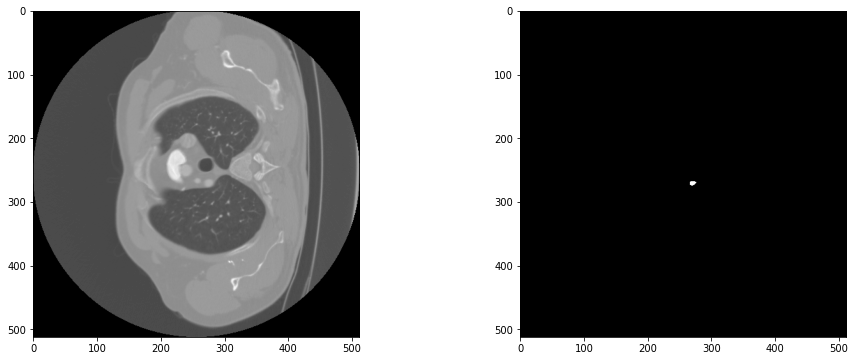

In [ ]:
# slice imagen
fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
imgSlice = img[:,:,171]
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
imgSlice = mask[:,:,171]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [ ]:
# Normalizar imagenes
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (512, 512, 342), numpy.ndarray)

**Imagenes de objeto a slides**

Las imagenes se convierten del formato NIFTI a slides tanto las mascaras como la imagenes.

Posteriormente cada slide se guarda en formato PNG y se almacenan en los directorios correspondientes.

In [ ]:
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
# Guardar el volumen slice
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [ ]:
# Slice imagenes y guardarlo
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [ ]:
# Leer y procesar los volumenes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'aorta1'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes2/img/I00001.nii (512, 512, 342) 1366 0.0 1.0
512 512 342
Slicing Z: 
[+] Slice saved: data/slices/img/aorta10-slice341_z.png
data/volumes2/img/I00001.nii, 342 slices created 



In [ ]:
# leer y procesar images y mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'aorta1'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes2/mask/IMG0001.dcm.nii (512, 512, 342) 1366 0.0 1.0
512 512 342
Slicing Z: 
[+] Slice saved: data/slices/mask/aorta10-slice341_z.png
data/volumes2/mask/IMG0001.dcm.nii, 342 slices created 



In [ ]:
# leer y procesar images volumes
for index, filename in enumerate(sorted(glob.iglob('data/slices/img/'+'*.png'))):
    img = cv2.imread(filename)
    print(filename, img.shape, np.min(img), np.max(img))

In [ ]:
list = os.listdir('data/slices/test/mask/img') # dir is your directory path
number_files = len(list)
print(number_files)

171


In [ ]:
list = os.listdir('data/slices/test/img/img') # dir is your directory path
number_files = len(list)
print(number_files)

171
